In [1]:

import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'


In [2]:


import numpy as np
import jax.numpy as jnp


In [3]:
from multigrid_cl import *

In [23]:
N = 32 #formerly 128


In [24]:
def fftk(shape, symmetric=True, finite=False, dtype=np.float32):
  """ Return k_vector given a shape (nc, nc, nc) and box_size
  """
  k = []
  for d in range(len(shape)):
    kd = np.fft.fftfreq(shape[d])
    kd *= 2 * np.pi
    kdshape = np.ones(len(shape), dtype='int')
    if symmetric and d == len(shape) - 1:
      kd = kd[:shape[d] // 2 + 1]
    kdshape[d] = len(kd)
    kd = kd.reshape(kdshape)

    k.append(kd.astype(dtype))
  del kd, kdshape
  return k



def laplace_kernel(kvec):
    """
  Compute the Laplace kernel from a given K vector
  Parameters:
  -----------
  kvec: array
    Array of k values in Fourier space
  Returns:
  --------
  wts: array
    Complex kernel
  """
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1. / kk
    imask = (~(kk == 0)).astype(int)
    wts *= imask
    return wts




kvec = fftk((N,N,N))
@jax.jit
def fft_potential(b):
    delta_k = jnp.fft.rfftn(b.reshape(N,N,N))
    laplace = laplace_kernel(kvec)
    pot_k = delta_k * laplace
    pot = jnp.fft.irfftn(pot_k)
    return pot

In [25]:
#fft_a = fft_potential(F)

In [70]:
import configuration
if jax.default_backend() == 'gpu':
    ptcl_spacing = 10/32 # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (N,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

conf = configuration.Configuration(ptcl_spacing, ptcl_grid_shape,mesh_shape=1)  # 1x mesh shape


In [71]:
np.__version__

'2.2.3'

In [72]:
from jaxpm.pm import linear_field, lpt, make_ode_fn,pm_forces
from jaxpm.kernels import *
import jax_cosmo as jc


#
snapshots = jnp.linspace(0.05,0.66,10)
seed=jax.random.PRNGKey(0)
k = jnp.logspace(-4, 1, 128)

omega_c = 0.3
sigma8 = 0.8
pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
pk = pk.at[-1].set(10**(-9))
k = k.at[-1].set(10**3)
pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))

# Create initial conditions
initial_conditions = linear_field(conf.mesh_shape, conf.box_size, pk_fn, seed=seed)

# Create particles
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in conf.mesh_shape]),axis=-1).reshape([-1,3])

cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
print("LPT")
# Initial displacement
dx, p, f = lpt(cosmo, initial_conditions, particles, 0.5)

print((particles+dx).shape, p.shape)
# Evolve the simulation forward

LPT
(32768, 3) (32768, 3)


In [73]:
from jaxpm.painting import cic_paint

@jax.jit
def cic_readout(mesh,part):
    
    shape = mesh.shape
    nx, ny, nz = shape[0], shape[1], shape[2]
    nc = [nx, ny, nz]
    
    fact = 1 #note this breaks x,y,z sym... do better
      #  print("fact")
    
  #  if len(part.shape) > 3:
    
    part = jnp.expand_dims(part,2) * fact
    floor = jnp.floor(part)
    connection = jnp.array([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1], [1., 1, 0],
                      [1., 0, 1], [0., 1, 1], [1., 1, 1]]])
    
    
    neighboor_coords =floor + connection
    kernel = 1. - jnp.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    neighboor_coords=jnp.array(neighboor_coords,dtype=jnp.int16)
    neighboor_coords = jnp.mod(neighboor_coords, nx)
    
    meshvals = mesh[tuple(neighboor_coords[0,:,:].T)]
    weightedvals = meshvals.T* kernel[0]
    values = jnp.sum(weightedvals, axis=-1)
    
    return values
F = jnp.ones(conf.mesh_shape)#jax.random.normal(seed,conf.mesh_shape)#jnp.random
def pm_forces_gs(positions, mesh_shape, extra_field, delta=None, r_split=0):
    """
    Computes gravitational forces on particles using a PM scheme
    """
    if delta is None:
        delta = cic_paint(jnp.zeros(mesh_shape), positions)#+extra_field
    else:
        delta = delta
    
    #currently a bit hacky for testing...
    U = extra_field#jnp.zeros(mesh_shape)    
    # Computes gravitational potential

    a = -poisson_multigrid(jnp.array(delta*1.65E4*1.0012), U, 2, 1, 1, 1, 1,laplace=laplace_beltrami_3d_pot,rho=F)
    #higher order stencil doesn't seem to work, 
    #force_vec = [(-1*jnp.roll(a,-2,axis=i)+8*jnp.roll(a,1,axis=i)-8*jnp.roll(a,-1,axis=i)+1*jnp.roll(a,-2,axis=i))/12 for i in range(3)]
    force_vec = [(1*jnp.roll(a,1,axis=i)-1*jnp.roll(a,-1,axis=i))/2 for i in range(3)]
    # Computes gravitational forces
    return jnp.stack([cic_readout(-force_vec[i], positions.reshape(1,-1,3)) 
                      for i in range(3)], axis=-1)


def make_ode_fn_gs(mesh_shape,extra_source):

    def nbody_ode(state, a, cosmo):
        """
        state is a tuple (position, velocities)
        """
        pos, vel = state
        forces = pm_forces_gs(pos, mesh_shape,extra_source) * 1.5 * cosmo.Omega_m

        # Computes the update of position (drift)
        dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

        # Computes the update of velocity (kick)
        dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
        return dpos, dvel

    return nbody_ode



In [74]:
lpt_field = cic_paint(jnp.zeros(conf.mesh_shape),particles+dx)

In [75]:
U_lpt = fft_potential(lpt_field)
#initial potential field guess, LPT potential

In [76]:
U = jnp.zeros(conf.mesh_shape)

In [77]:
pp = particles+dx

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(0.0, 32.0)

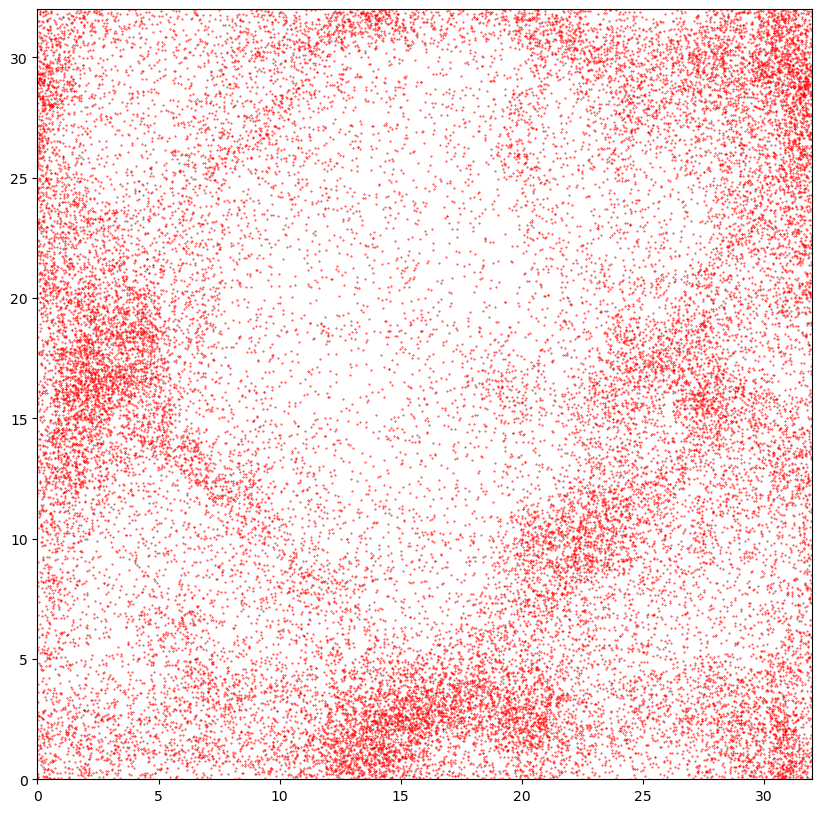

In [82]:
%pylab inline
fig, ax = plt.subplots(figsize=(10,10))

plt.plot(np.mod(pp[:,1],32),np.mod(pp[:,2],32),"r.",markersize=0.75)
plt.xlim(0,32)
plt.ylim(0,32)


In [88]:
pp[:32*32]

Array([[-2.7466497 , -0.21372643, -0.08901487],
       [-3.0115752 ,  0.3446395 , -0.19476843],
       [-3.396183  ,  0.2589535 ,  0.43398035],
       ...,
       [26.610418  , -4.026159  , 29.873253  ],
       [26.806688  , -3.6786985 , 30.769611  ],
       [27.464304  , -2.7885692 , 31.230059  ]], dtype=float32)

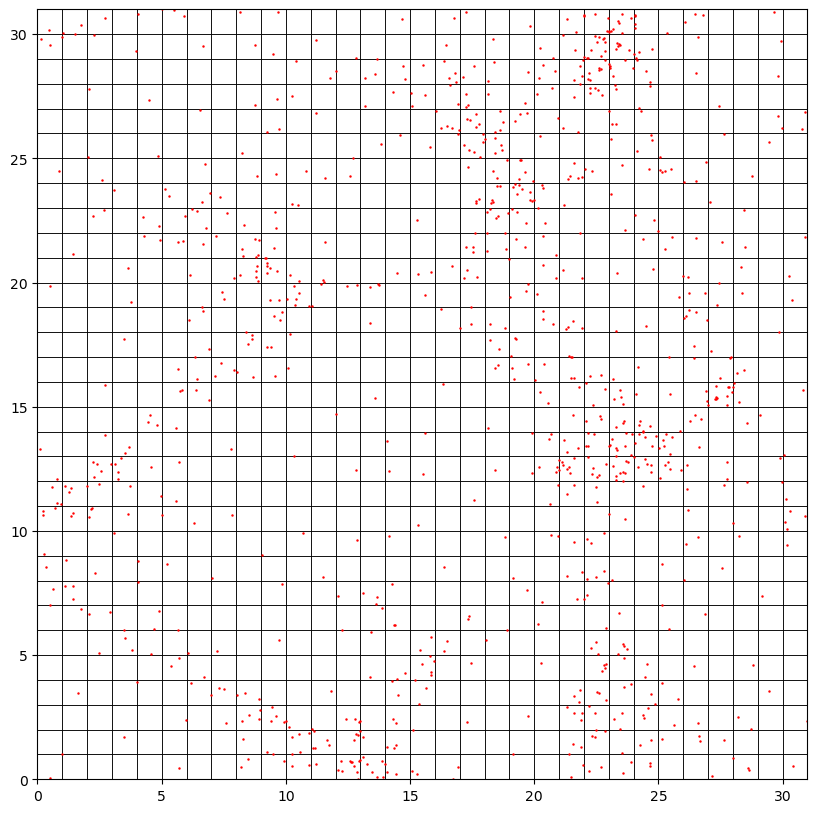

In [94]:
from matplotlib import patches

from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

x=particles[:32*32*1,0].reshape(32,32)
y=particles[:32*32*1,2].reshape(32,32)

Nx, Ny = x.shape
fig, ax = plt.subplots(figsize=(10,10))

for i in range(Nx - 1):
    for j in range(Ny - 1):
        # Get the four corners of the cell by averaging adjacent points
        x0 = 0.25 * (x[i, j] + x[i+1, j] + x[i, j+1] + x[i+1, j+1])
        y0 = 0.25 * (y[i, j] + y[i+1, j] + y[i, j+1] + y[i+1, j+1])

        # Define the quad corners (in counter-clockwise order)
        quad_x = [x[i, j], x[i+1, j], x[i+1, j+1], x[i, j+1]]
        quad_y = [y[i, j], y[i+1, j], y[i+1, j+1], y[i, j+1]]
        verts = list(zip(quad_x, quad_y))

        patch = patches.Polygon(verts, closed=True, fill=False, edgecolor='black', linewidth=0.5)
        ax.add_patch(patch)

ax.set_aspect('equal')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.plot(np.mod(pp[:32*32,0],32),np.mod(pp[:32*32,2],32),"r.",markersize=1.5)
plt.xlim(0,31)
plt.ylim(0,31)
#plt.plot((res_mg_MM[0][-1]-dd_eta[-1][-1])[:64*64*1][:,0],(res_mg_MM[0][-1]-dd_eta[-1][-1])[:64*64*1][:,2],"rx",markersize=1.0)
show()


In [98]:
ii = cic_paint(jnp.zeros((N,N,N)),pp)

(0.0, 31.0)

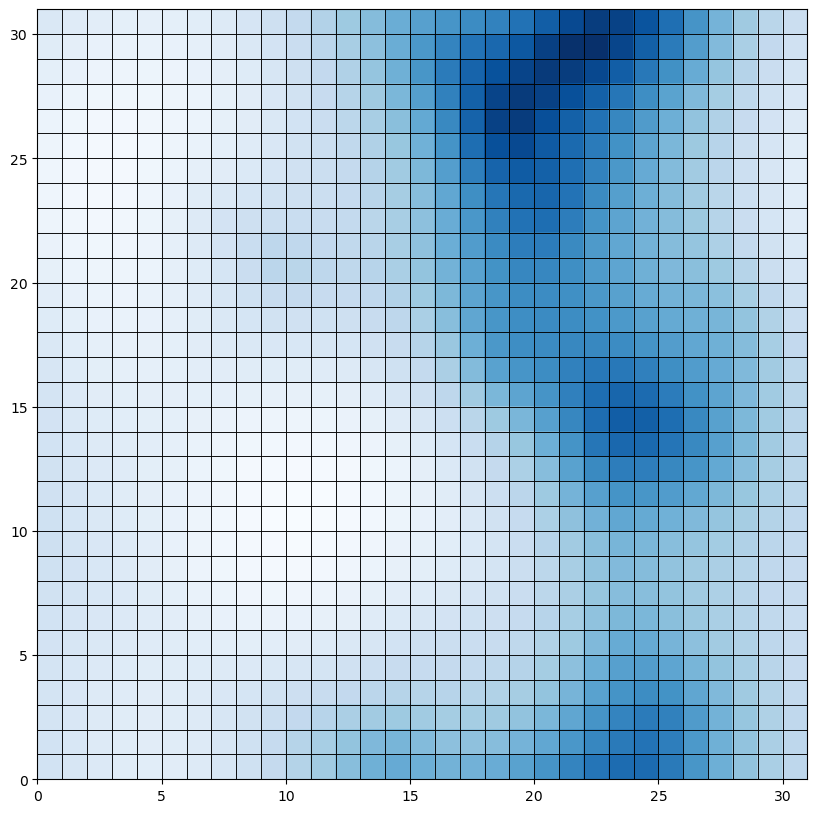

In [117]:
fig, ax = plt.subplots(figsize=(10,10))

imshow(U_lpt[:,0,::-1].T,cmap="Blues",extent=[0,32,0,32])

x=particles[:32*32*1,0].reshape(32,32)
y=particles[:32*32*1,2].reshape(32,32)

Nx, Ny = x.shape

for i in range(Nx - 1):
    for j in range(Ny - 1):
        # Get the four corners of the cell by averaging adjacent points
        x0 = 0.25 * (x[i, j] + x[i+1, j] + x[i, j+1] + x[i+1, j+1])
        y0 = 0.25 * (y[i, j] + y[i+1, j] + y[i, j+1] + y[i+1, j+1])

        # Define the quad corners (in counter-clockwise order)
        quad_x = [x[i, j], x[i+1, j], x[i+1, j+1], x[i, j+1]]
        quad_y = [y[i, j], y[i+1, j], y[i+1, j+1], y[i, j+1]]
        verts = list(zip(quad_x, quad_y))

        patch = patches.Polygon(verts, closed=True, fill=False, edgecolor='black', linewidth=0.5)
        ax.add_patch(patch)

ax.set_aspect('equal')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
#plt.plot(np.mod(pp[:32*32,0],32),np.mod(pp[:32*32,2],32),"r.",markersize=1.5)
plt.xlim(0,31)
plt.ylim(0,31)

In [14]:
seed=jax.random.PRNGKey(0)


In [15]:
U = jnp.zeros(conf.mesh_shape)#jax.random.normal(seed,conf.mesh_shape)#jnp.random
F = jnp.ones(conf.mesh_shape)#jax.random.normal(seed,conf.mesh_shape)#jnp.random

In [16]:
a = -poisson_multigrid(jnp.array(lpt_field*1.65E4*1.0012), U, 2, 1, 1, 1, 3,laplace=laplace_beltrami_3d_pot,rho=F)
#a2 = -poisson_multigrid(jnp.array(lpt_field*1.65E4*1.0012), U_lpt*0.9, 1, 1, 1, 1, 1)

using euclidean triad!


In [17]:
from scipy import stats

stats.pearsonr(a.flatten(),U_lpt.flatten())#,stats.pearsonr(a2.flatten(),U_lpt.flatten())

PearsonRResult(statistic=np.float32(0.92102873), pvalue=np.float64(0.0))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


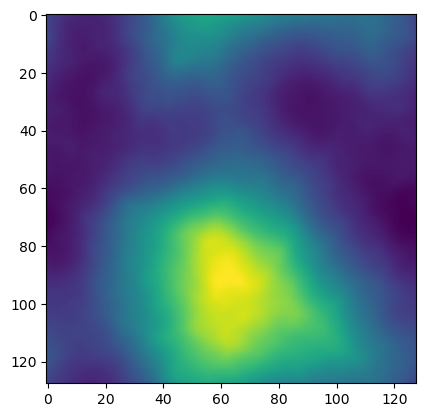

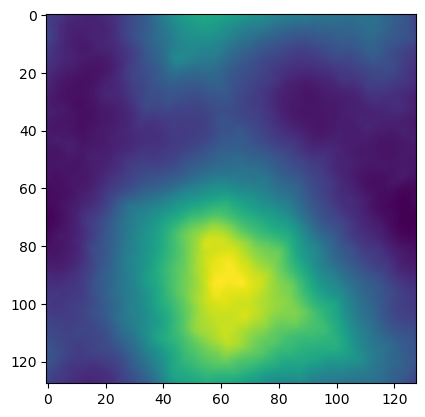

In [31]:
%pylab inline
imshow(a[100])
show()
imshow(U_lpt[100])

In [32]:
from jax.experimental.ode import odeint
import time

res = odeint(make_ode_fn(conf.mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
st = time.time()
res_gs_lptstart = odeint(make_ode_fn_gs(conf.mesh_shape,U_lpt ), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
print(time.time()-st)

using euclidean triad!
2 (128, 128, 128, 3, 3) (128, 128, 128)
restriction (128, 128, 128)
wr (128, 128, 128)
restriction (128, 128, 128, 3, 3)
wr (128, 128, 128, 3, 3)
(64, 64, 64, 3, 3)
restriction (128, 128, 128)
wr (128, 128, 128)
1 (64, 64, 64, 3, 3) (64, 64, 64)
67.61015343666077


In [33]:
st = time.time()

res_gs_unistart = odeint(make_ode_fn_gs(conf.mesh_shape,jnp.zeros(conf.mesh_shape) ), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
print(time.time()-st)

using euclidean triad!
2 (128, 128, 128, 3, 3) (128, 128, 128)
restriction (128, 128, 128)
wr (128, 128, 128)
restriction (128, 128, 128, 3, 3)
wr (128, 128, 128, 3, 3)
(64, 64, 64, 3, 3)
restriction (128, 128, 128)
wr (128, 128, 128)
1 (64, 64, 64, 3, 3) (64, 64, 64)
104.56359124183655


In [35]:

field = cic_paint(jnp.zeros(conf.mesh_shape),res[0][-1])
field_lptstart = cic_paint(jnp.zeros(conf.mesh_shape),res_gs_lptstart[0][-1])
field_unistart = cic_paint(jnp.zeros(conf.mesh_shape),res_gs_unistart[0][-1])

In [36]:
from scipy import stats
#.stats.pearsonr

In [38]:
stats.pearsonr(field.flatten(),field_unistart.flatten())

PearsonRResult(statistic=np.float32(0.8818719), pvalue=np.float64(0.0))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_133230/2347104294.py:2: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(field)[100])


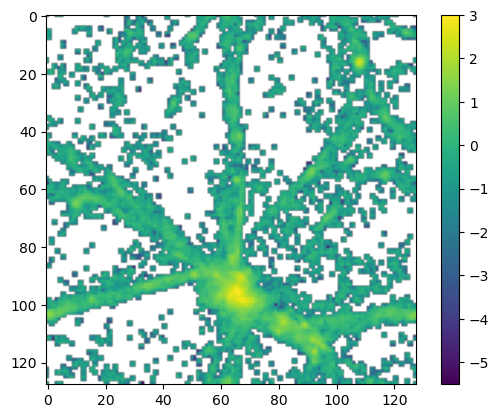

/tmp/ipykernel_133230/2347104294.py:5: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(field_unistart)[100])


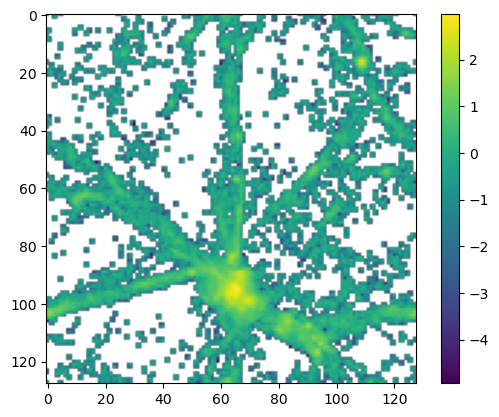

/tmp/ipykernel_133230/2347104294.py:10: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(field_lptstart)[100])


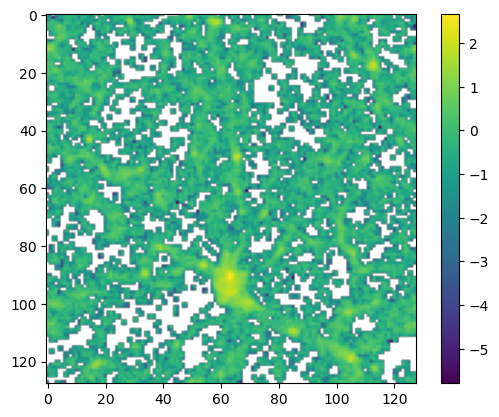

In [43]:
%pylab inline
imshow(np.log10(field)[100])
colorbar()
show()
imshow(np.log10(field_unistart)[100])
colorbar()
show()


imshow(np.log10(field_lptstart)[100])
colorbar()
show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


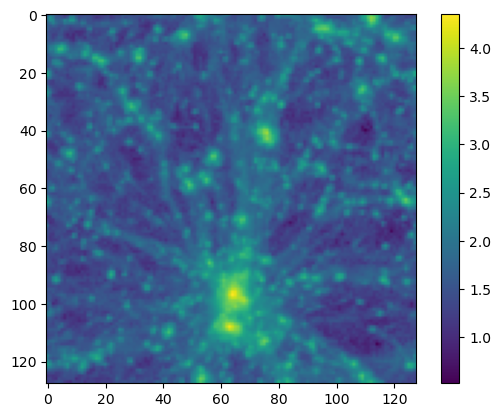

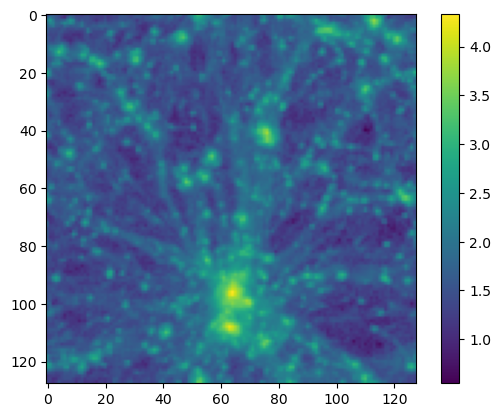

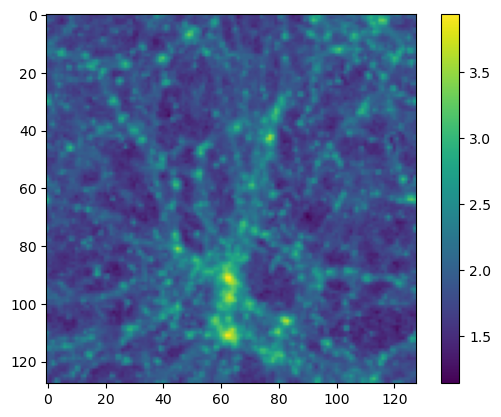

In [42]:
%pylab inline
imshow(np.log10(field.sum(axis=0)))
colorbar()
show()
imshow(np.log10(field_unistart.sum(axis=0)))
colorbar()
show()


imshow(np.log10(field_lptstart.sum(axis=0)))
colorbar()
show()